In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
# read data from file:
merge_train0_no0 = pd.read_csv('C:/data/Kaggle_ASHRAE_energy/merge_train0_no0.csv')
merge_train0_no0.head()

,site_id,building_id,0,1,2,3,4,5,6,7,...,airtemp,sealev,dewtemp,windsp,North,West,South,nowind,dewair,meter_reading
0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.6980,0.6070,0.8640,0.4255,0.0,0.0,0.0,0.0,0.9463,68.220
1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.7060,0.5970,0.8735,0.2356,0.0,0.0,0.0,0.0,0.9470,81.424
2,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.7407,0.5957,0.8820,0.1488,0.0,0.0,0.0,0.0,0.9307,70.020
3,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.7630,0.5900,0.8735,0.2107,1.0,0.0,0.0,0.0,0.9146,70.621
4,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.7344,0.5850,0.8916,0.2356,1.0,0.0,0.0,0.0,0.9390,74.022


In [4]:
merge_train0_no0.shape

(11486383, 29)

In [5]:
# find out outliners
idx = merge_train0_no0.meter_reading.sort_values(ascending= False).head(24).index
idx

Int64Index([8001458, 9409192, 7669739, 8001455, 8001456, 8001457, 7266880,
            7995174, 7995993, 7261283, 7999011, 7999012, 7999013, 7999010,
            7995294, 8003195, 8003194, 8003193, 6439765, 9409091, 7995994,
            7669738, 7669736, 7669737],
           dtype='int64')

In [6]:
# delete outliners
merge_train0_no0.drop(list(idx), inplace=True)

In [7]:
merge_train0_no0.shape,merge_train0_no0

((11486359, 29),
           site_id  building_id    0    1    2    3    4    5    6    7  ...  \
 0               0            0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
 1               0            0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
 2               0            0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
 3               0            0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
 4               0            0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
 ...           ...          ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
 11486378       15         1448  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...   
 11486379       15         1448  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...   
 11486380       15         1448  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...   
 11486381       15         1448  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...   
 11486382       15         1448  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...   
 
           airtemp  s

In [8]:
merge_train0_no0.reset_index(inplace = True, drop= True)
merge_train0_no0

,site_id,building_id,0,1,2,3,4,5,6,7,...,airtemp,sealev,dewtemp,windsp,North,West,South,nowind,dewair,meter_reading
0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.6980,0.6070,0.8640,0.4255,0.0,0.0,0.0,0.0,0.9463,68.220
1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.7060,0.5970,0.8735,0.2356,0.0,0.0,0.0,0.0,0.9470,81.424
2,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.7407,0.5957,0.8820,0.1488,0.0,0.0,0.0,0.0,0.9307,70.020
3,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.7630,0.5900,0.8735,0.2107,1.0,0.0,0.0,0.0,0.9146,70.621
4,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.7344,0.5850,0.8916,0.2356,1.0,0.0,0.0,0.0,0.9390,74.022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11486354,15,1448,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.4133,0.4822,0.4375,0.2356,0.0,0.0,1.0,0.0,0.8930,3.400
11486355,15,1448,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.4106,0.4785,0.4230,0.3180,0.0,0.0,1.0,0.0,0.8860,2.700
11486356,15,1448,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.4106,0.4797,0.4507,0.2107,0.0,0.0,1.0,0.0,0.9030,3.050
11486357,15,1448,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.4028,0.4858,0.4587,0.1901,0.0,0.0,1.0,0.0,0.9130,3.125


In [9]:
meter_reading = merge_train0_no0.meter_reading.copy()
meter_reading

0           68.220
1           81.424
2           70.020
3           70.621
4           74.022
             ...  
11486354     3.400
11486355     2.700
11486356     3.050
11486357     3.125
11486358     2.850
Name: meter_reading, Length: 11486359, dtype: float64

In [10]:
meter_reading = np.log1p(meter_reading)
meter_reading

0           4.237290
1           4.411877
2           4.262962
3           4.271388
4           4.317781
              ...   
11486354    1.481605
11486355    1.308333
11486356    1.398717
11486357    1.417066
11486358    1.348073
Name: meter_reading, Length: 11486359, dtype: float64

In [11]:
# need to rescale the meter_reading:
from sklearn.preprocessing import RobustScaler, MinMaxScaler
rob_y = RobustScaler()
mm_y = MinMaxScaler()

In [12]:
meter_reading_prepared = mm_y.fit_transform(rob_y.fit_transform(meter_reading.values.reshape(-1,1)))
meter_reading_prepared

array([[0.44251845],
       [0.46075302],
       [0.44519971],
       ...,
       [0.14604605],
       [0.14796251],
       [0.14075661]])

In [13]:
pd.Series(meter_reading_prepared.reshape(-1,))

0           0.442518
1           0.460753
2           0.445200
3           0.446080
4           0.450925
              ...   
11486354    0.154703
11486355    0.136606
11486356    0.146046
11486357    0.147963
11486358    0.140757
Length: 11486359, dtype: float64

In [14]:
meter_reading.update(pd.Series(meter_reading_prepared.reshape(-1,)))
meter_reading

0           0.442518
1           0.460753
2           0.445200
3           0.446080
4           0.450925
              ...   
11486354    0.154703
11486355    0.136606
11486356    0.146046
11486357    0.147963
11486358    0.140757
Name: meter_reading, Length: 11486359, dtype: float64

In [15]:
merge_train0_no0.update(meter_reading)
merge_train0_no0

,site_id,building_id,0,1,2,3,4,5,6,7,...,airtemp,sealev,dewtemp,windsp,North,West,South,nowind,dewair,meter_reading
0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.6980,0.6070,0.8640,0.4255,0.0,0.0,0.0,0.0,0.9463,0.442518
1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.7060,0.5970,0.8735,0.2356,0.0,0.0,0.0,0.0,0.9470,0.460753
2,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.7407,0.5957,0.8820,0.1488,0.0,0.0,0.0,0.0,0.9307,0.445200
3,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.7630,0.5900,0.8735,0.2107,1.0,0.0,0.0,0.0,0.9146,0.446080
4,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.7344,0.5850,0.8916,0.2356,1.0,0.0,0.0,0.0,0.9390,0.450925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11486354,15,1448,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.4133,0.4822,0.4375,0.2356,0.0,0.0,1.0,0.0,0.8930,0.154703
11486355,15,1448,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.4106,0.4785,0.4230,0.3180,0.0,0.0,1.0,0.0,0.8860,0.136606
11486356,15,1448,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.4106,0.4797,0.4507,0.2107,0.0,0.0,1.0,0.0,0.9030,0.146046
11486357,15,1448,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.4028,0.4858,0.4587,0.1901,0.0,0.0,1.0,0.0,0.9130,0.147963


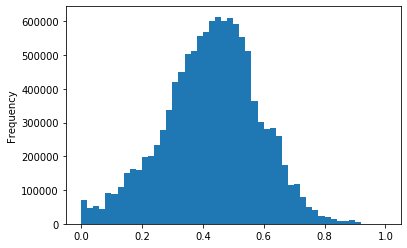

In [16]:
meter_reading.plot.hist(bins=50)

In [17]:
X = [merge_train0_no0.building_id.values, merge_train0_no0.drop(['site_id','building_id','timestamp','meter_reading'], axis=1).values]
y = merge_train0_no0.meter_reading.values

In [18]:
def build_model():
    inputs = []
    embeddings = []
    
    input_building_id = tf.keras.layers.Input(shape=(1,), name='input_building_id')
    embedding = tf.keras.layers.Embedding(1449, 10, name = 'building_id_emb')(input_building_id) #, input_length=1
    embedding = tf.keras.layers.Flatten()(embedding)
    embedding = tf.keras.layers.Dropout(0.1)(embedding)
    embedding = tf.keras.layers.Dense(10, activation='relu')(embedding)
    embedding = tf.keras.layers.Dropout(0.05)(embedding)
    embedding = tf.keras.layers.BatchNormalization()(embedding)
    inputs.append(input_building_id)
    embeddings.append(embedding)
    
    input_numeric = tf.keras.layers.Input(shape=(25,), name = 'input_numeric')
#    embedding_num = tf.keras.layers.Dense(35)(input_numeric)
    inputs.append(input_numeric)
    embeddings.append(input_numeric)
    
    main_Layers = tf.keras.layers.Concatenate()(embeddings)
    
    main_Layers = tf.keras.layers.Dense(40, activation='relu')(main_Layers)
    main_Layers = tf.keras.layers.BatchNormalization()(main_Layers)
    main_Layers = tf.keras.layers.Dropout(0.05)(main_Layers)
    main_Layers = tf.keras.layers.Dense(20, activation='relu')(main_Layers)
    main_Layers = tf.keras.layers.BatchNormalization()(main_Layers)
    main_Layers = tf.keras.layers.Dropout(0.05)(main_Layers)
    main_Layers = tf.keras.layers.Dense(5, activation='relu')(main_Layers)
    main_Layers = tf.keras.layers.BatchNormalization()(main_Layers)
#    main_Layer = tf.keras.layers.Dropout(0.05)(main_Layer)
    output = tf.keras.layers.Dense(1)(main_Layers)

    model = tf.keras.Model(inputs, output)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001,beta_1=0.9,beta_2=0.999, epsilon=1e-08), 
                  loss=tf.keras.losses.mean_squared_error
    #              , metrics=['mae']
                 )
    return model

In [19]:
model1 = build_model()

In [20]:
model1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_building_id (InputLayer)  [(None, 1)]          0                                            
__________________________________________________________________________________________________
building_id_emb (Embedding)     (None, 1, 10)        14490       input_building_id[0][0]          
__________________________________________________________________________________________________
flatten (Flatten)               (None, 10)           0           building_id_emb[0][0]            
__________________________________________________________________________________________________
dropout (Dropout)               (None, 10)           0           flatten[0][0]                    
______________________________________________________________________________________________

In [21]:
history = model1.fit(X, y, epochs=1
                     , batch_size=64
#                     , verbose=0
                    )

Train on 11486359 samples
11486359/11486359 [==============================] - 505s 44us/sample - loss: nan


In [51]:
model_check = model1

In [52]:
model_check.get_config()

{'name': 'model_2',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 1),
    'dtype': 'float32',
    'sparse': False,
    'name': 'input_5'},
   'name': 'input_5',
   'inbound_nodes': []},
  {'class_name': 'Embedding',
   'config': {'name': 'embedding_3',
    'trainable': True,
    'batch_input_shape': (None, None),
    'dtype': 'float32',
    'input_dim': 1449,
    'output_dim': 20,
    'embeddings_initializer': {'class_name': 'RandomUniform',
     'config': {'minval': -0.05, 'maxval': 0.05, 'seed': None}},
    'embeddings_regularizer': None,
    'activity_regularizer': None,
    'embeddings_constraint': None,
    'mask_zero': False,
    'input_length': None},
   'name': 'embedding_3',
   'inbound_nodes': [[['input_5', 0, 0, {}]]]},
  {'class_name': 'Flatten',
   'config': {'name': 'flatten_2',
    'trainable': True,
    'dtype': 'float32',
    'data_format': 'channels_last'},
   'name': 'flatten_2',
   'inbound_nodes': [[['embedding_3', 0, 0, {}]]]},

In [107]:
def get_keras_data(df, num_cols, cat_cols):
    cols = num_cols + cat_cols
    X = {col: np.array(df[col]) for col in cols}
    return X

In [110]:
test_100 = merge_train0_no0.head(100).copy()
test_100

,site_id,building_id,0,1,2,3,4,5,6,7,...,airtemp,sealev,dewtemp,windsp,North,West,South,nowind,dewair,meter_reading
0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.6980,0.6070,0.8640,0.4255,0.0,0.0,0.0,0.0,0.9463,0.000855
1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.7060,0.5970,0.8735,0.2356,0.0,0.0,0.0,0.0,0.9470,0.001020
2,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.7407,0.5957,0.8820,0.1488,0.0,0.0,0.0,0.0,0.9307,0.000877
3,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.7630,0.5900,0.8735,0.2107,1.0,0.0,0.0,0.0,0.9146,0.000885
4,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.7344,0.5850,0.8916,0.2356,1.0,0.0,0.0,0.0,0.9390,0.000928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.7630,0.6250,0.8735,0.1694,1.0,0.0,0.0,0.0,0.9146,0.000902
96,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.7630,0.6240,0.8640,0.2560,1.0,0.0,0.0,0.0,0.9100,0.000953
97,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.7200,0.6274,0.8640,0.3635,1.0,0.0,0.0,0.0,0.9336,0.000817
98,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.7124,0.6350,0.8460,0.2769,1.0,0.0,0.0,0.0,0.9290,0.000832
